# 2. Preprocessing
## 2.01 Variable selection

**Linear correlation**

We want to shortly investigate which features might carry the most potential for use in the flood model. 
In order to do this, we evaluate the correlation between a the upstream mean of an ERA5 variable or a derived variable against discharge at an example river gridpoint.
Thus, we are comparing time series of predictor variables with timeseries of the predictand.

As we want to limit the features for the LocalModel, which is supposed to predict the leftover residuals from the TransportModel mainly consisting of the local impacts arising from precipitation and other corresponding variables, we filter the data in the time dimension to only incude days with measurable amounts of precipitation recorded and furthermore look at the change of discharge from one day to another, instead of absolute values.

To quantify the impact of each feature, we use a filter method with the pearson correlation coefficient.

The point of interest shall be `latitude=48.35, longitude=13.95`.


In [1]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

To be able to import custom functions, we need to add the repository path to the system's python path with `sys.path.append('../../')`.

In [2]:
import sys
sys.path.append('../../')

In [3]:
from python.aux.utils_floodmodel import get_mask_of_basin, add_shifted_variables, reshape_scalar_predictand

In [4]:
# load data
era5 = xr.open_dataset('../../data/smallsampledata-era5.nc')
glofas = xr.open_dataset('../../data/smallsampledata-glofas.nc')
era5

<xarray.Dataset>
Dimensions:      (latitude: 13, longitude: 25, time: 5478)
Coordinates:
  * time         (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1995-12-31
  * longitude    (longitude) float32 8.0 8.25 8.5 8.75 ... 13.25 13.5 13.75 14.0
  * latitude     (latitude) float32 50.0 49.75 49.5 49.25 ... 47.5 47.25 47.0
Data variables:
    cp           (time, latitude, longitude) float32 ...
    lsp          (time, latitude, longitude) float32 ...
    swvl1        (time, latitude, longitude) float32 ...
    tcwv         (time, latitude, longitude) float32 ...
    ro           (time, latitude, longitude) float32 ...
    rtp_500-850  (time, latitude, longitude) float32 ...

Note: `rtp_500-850` is the **relative topography**, a derived variable by subtracting the geopotential in 850 hPa from the geopotential height in 500 hPa, i.e. `era5['z'].sel(level=500)-era5['z'].sel(level=850)`. It is proportional to the mass weighted (=barometric) mean temperature between those levels.

In [5]:
def feature_preproc(era5, glofas, timeinit, timeend):

    features = ['cp', 'lsp', 'ro', 'rtp_500-850', 'tcwv', 'swvl1']
    era5_features = era5[features]

    # interpolate to glofas grid
    era5_features = era5_features.interp(latitude=glofas.latitude,
                                         longitude=glofas.longitude)
    # time subset
    era5_features = era5_features.sel(time=slice(timeinit, timeend))
    glofas = glofas.sel(time=slice(timeinit, timeend))

    # select the point of interest
    #poi = dict(latitude=48.403, longitude=15.615)  # krems (lower austria)
    poi = dict(latitude=48.35, longitude=13.95)  # point in upper austria

    dummy = glofas['dis'].isel(time=0)
    danube_catchment = get_mask_of_basin(dummy, kw_basins='Danube')
    X = era5_features.where(danube_catchment).mean(['latitude', 'longitude'])

    # select area of interest and average over space for all features
    dis = glofas.interp(poi)
    y = dis.diff('time', 1)  # compare predictors to change in discharge
    
    shifts = range(1,3)
    notshift_vars = ['swvl1', 'tcwv', 'rtp_500-850']
    shift_vars = [v for v in X.data_vars if not v in notshift_vars]

    X = add_shifted_variables(X, shifts, variables=shift_vars)
    
    Xda, yda = reshape_scalar_predictand(X, y)  # reshape into dimensions (time, feature)
    return Xda, yda

In [6]:
import seaborn as sns
from sklearn.feature_selection import RFE

def generate_heatmap(X, y, descr='description'):
    df = pd.DataFrame(data=X.values, columns=X.features.values, index=X.time.values)
    df['predictand'] = y
    plt.figure(figsize=(25,25))
    cor = df.corr()
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.show()
    cor_predictand = abs(cor['predictand'])
    feature_importance = cor_predictand[cor_predictand > 0.2]
    print(descr)
    print(feature_importance)
    return feature_importance

Now that all methods are set up, lets have a look at different time periods and generate a correlation heatmap between all features, with a printed list of features >0.2 correlation coeff at the end. Lets also save the important feature into a new list and evaluate it at the end.

In [7]:
important_features = []

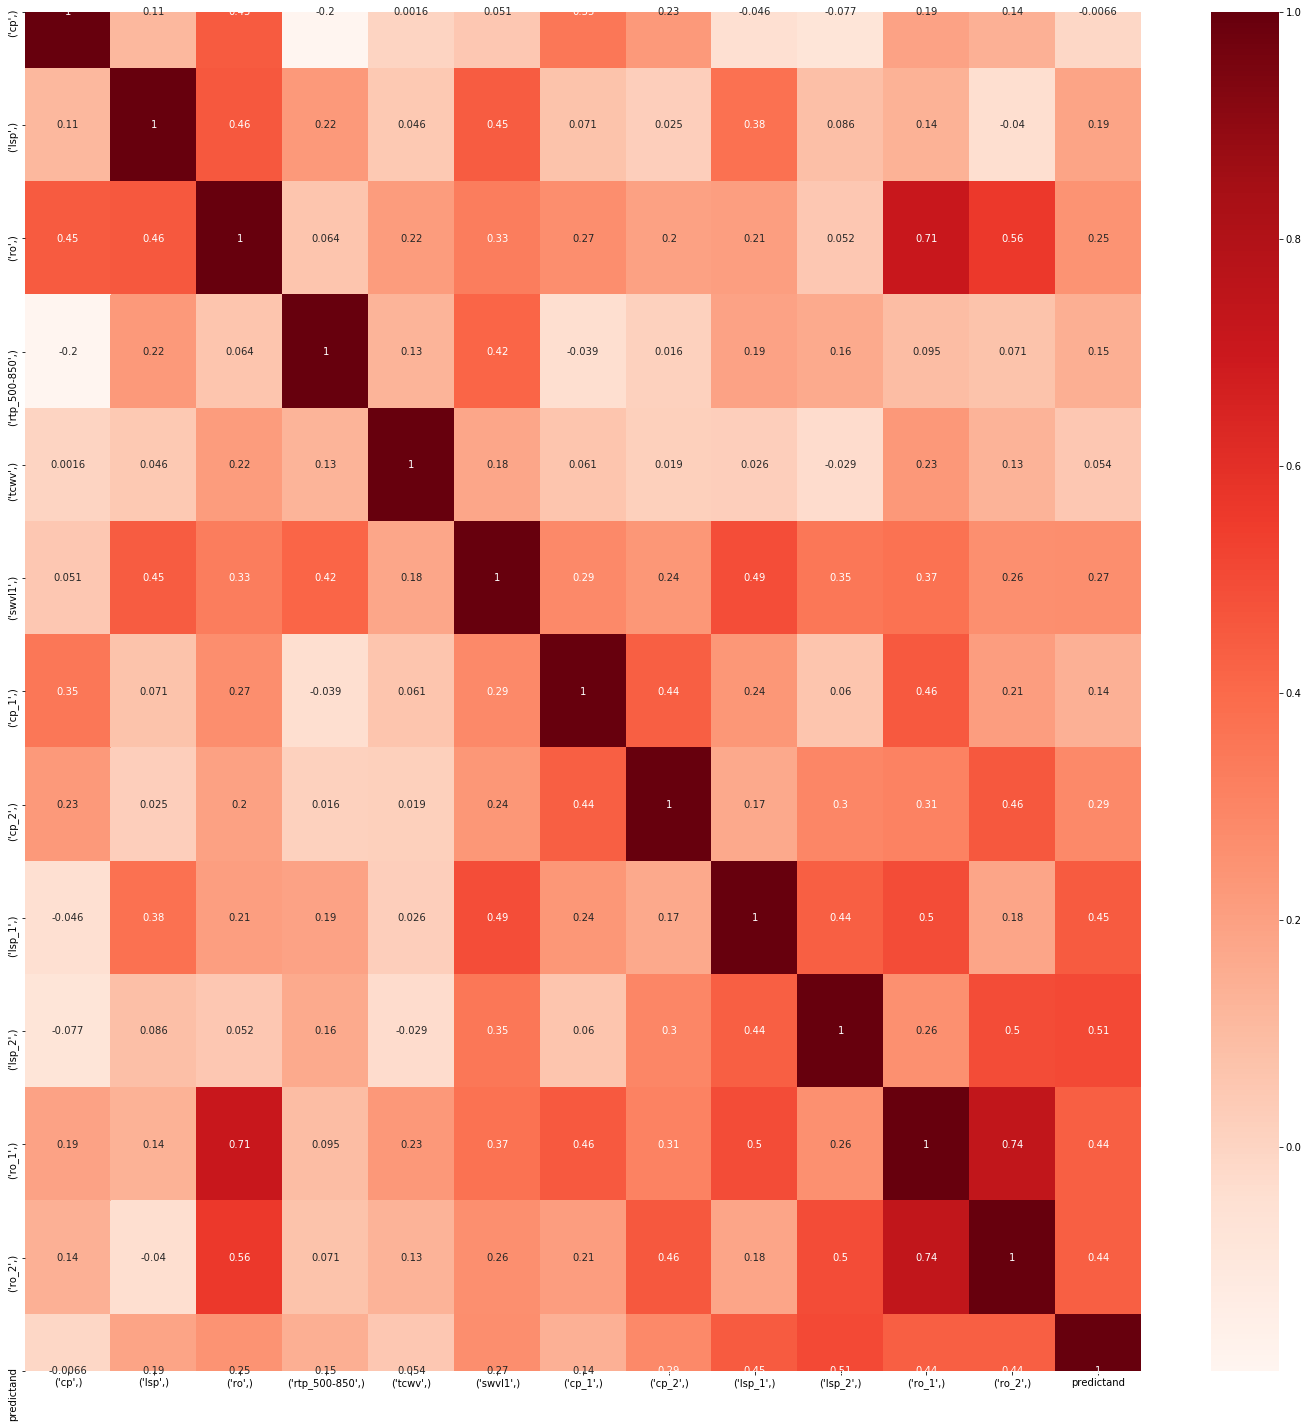

1980-1984; only days with precip > 1mm
(ro,)         0.247870
(swvl1,)      0.267278
(cp_2,)       0.285266
(lsp_1,)      0.450470
(lsp_2,)      0.507095
(ro_1,)       0.435793
(ro_2,)       0.437846
predictand    1.000000
Name: predictand, dtype: float64


In [8]:
timeinit, timeend = '1980', '1984'
X, y = feature_preproc(era5=era5, glofas=glofas, timeinit=timeinit, timeend=timeend)

Xtp = X.sel(features=('cp',)) + X.sel(features=('lsp',))
Xprecip = Xtp.where(Xtp>1/1000, drop=True)
X = X.where(Xprecip)
y = y.where(Xprecip)

ft = generate_heatmap(X=X, y=y, descr=f'{timeinit}-{timeend}; only days with precip > 1mm')
important_features.append(ft)

/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


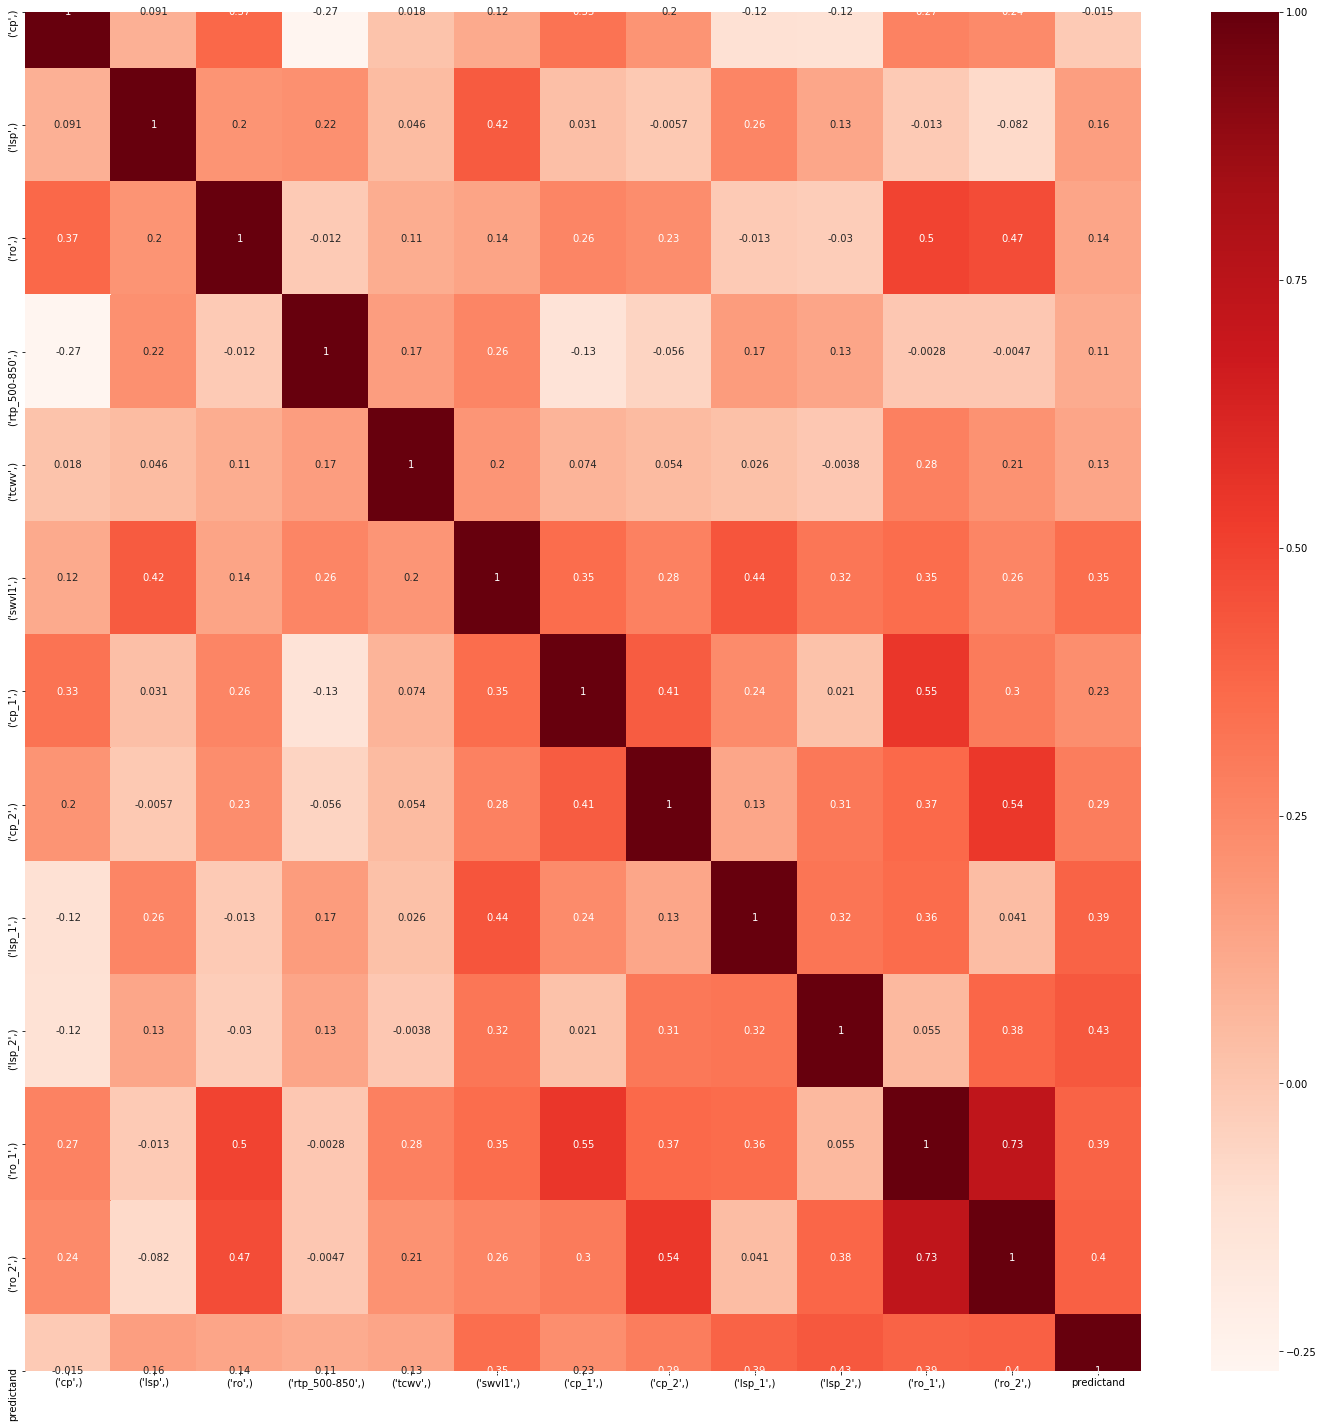

1985-1989; only days with precip > 1mm
(swvl1,)      0.346954
(cp_1,)       0.226712
(cp_2,)       0.287686
(lsp_1,)      0.389427
(lsp_2,)      0.427370
(ro_1,)       0.387354
(ro_2,)       0.396332
predictand    1.000000
Name: predictand, dtype: float64


In [9]:
timeinit, timeend = '1985', '1989'
X, y = feature_preproc(era5=era5, glofas=glofas, timeinit=timeinit, timeend=timeend)

Xtp = X.sel(features=('cp',)) + X.sel(features=('lsp',))
Xprecip = Xtp.where(Xtp>1/1000, drop=True)
X = X.where(Xprecip)
y = y.where(Xprecip)

ft = generate_heatmap(X=X, y=y, descr=f'{timeinit}-{timeend}; only days with precip > 1mm')
important_features.append(ft)

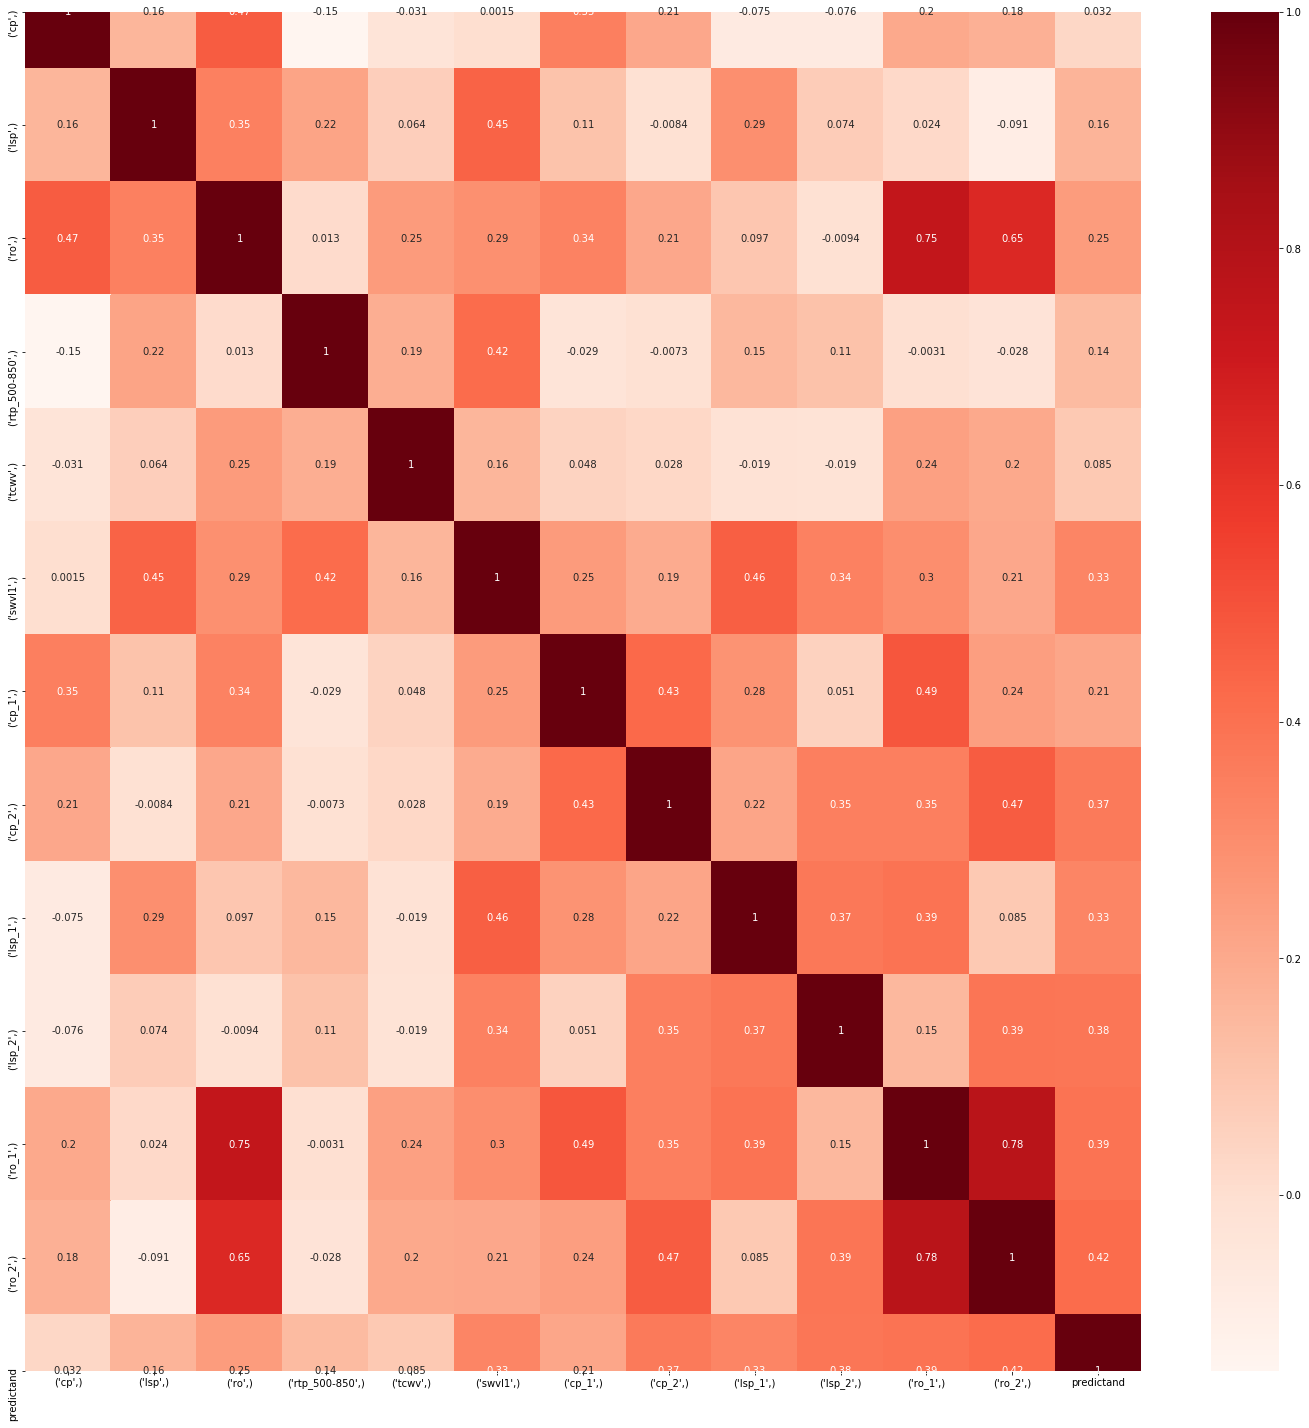

1990-1995; only days with precip > 1mm
(ro,)         0.249801
(swvl1,)      0.328639
(cp_1,)       0.213713
(cp_2,)       0.369377
(lsp_1,)      0.328067
(lsp_2,)      0.382326
(ro_1,)       0.392958
(ro_2,)       0.417626
predictand    1.000000
Name: predictand, dtype: float64


In [10]:
timeinit, timeend = '1990', '1995'
X, y = feature_preproc(era5=era5, glofas=glofas, timeinit=timeinit, timeend=timeend)
Xtp = X.sel(features=('cp',)) + X.sel(features=('lsp',))

Xprecip = Xtp.where(Xtp>1/1000, drop=True)
X = X.where(Xprecip)
y = y.where(Xprecip)
ft = generate_heatmap(X=X, y=y, descr=f'{timeinit}-{timeend}; only days with precip > 1mm')
important_features.append(ft)

Looking at long periods of time the resulting feature importance is:

cp, lsp, ro, cp-1, lsp-1, ro-1, swvl1

In [11]:
for entry in important_features:
    print(entry[:-1])
    print('#'*30)

(ro,)       0.247870
(swvl1,)    0.267278
(cp_2,)     0.285266
(lsp_1,)    0.450470
(lsp_2,)    0.507095
(ro_1,)     0.435793
(ro_2,)     0.437846
Name: predictand, dtype: float64
##############################
(swvl1,)    0.346954
(cp_1,)     0.226712
(cp_2,)     0.287686
(lsp_1,)    0.389427
(lsp_2,)    0.427370
(ro_1,)     0.387354
(ro_2,)     0.396332
Name: predictand, dtype: float64
##############################
(ro,)       0.249801
(swvl1,)    0.328639
(cp_1,)     0.213713
(cp_2,)     0.369377
(lsp_1,)    0.328067
(lsp_2,)    0.382326
(ro_1,)     0.392958
(ro_2,)     0.417626
Name: predictand, dtype: float64
##############################


Lastly, we look at a specific flooding example: May/June 2013

In [13]:
timeinit = '2013-05-30'
timeend = '2013-06-15'
X, y = feature_preproc(era5=era5, glofas=glofas, timeinit=timeinit, timeend=timeend)

Xtp = X.sel(features=('cp',)) + X.sel(features=('lsp',))
Xprecip = Xtp.where(Xtp>1/1000, drop=True)
X = X.where(Xprecip)
y = y.where(Xprecip)

ft = generate_heatmap(X=X, y=y, descr=f'{timeinit}-{timeend}; only days with precip > 1mm')

As the sample dataset does not include 2013, this image can only be created using the full dataset. This image was created with the full dataset.

![Flooding-case-2013](correlation_2013.png)

In [16]:
ft[ft > 0.6]

predictand    1.0
Name: predictand, dtype: float64

As can be seen, the resulting features take on a different take. It is not suprising, that **cp** is not contained in the stricter requirement of coef > 0.6, because at the event in question, there was largerly orographically induced precipitation (so called, Nordstau), which is contributed as **lsp**.

Additionally, **tcwv-1** and **tcwv-2** exhibit a hight correlation coefficient as well. But looking at inter-feature colinearity, we can quickly deduce that both of those variables are highly correlated with **lsp** as well (which makes perfect sense from a physical pov, due to the orographic induced lifting, moisturizing the atmosphere over extended periods of time), which means we can safely ignore those features, as their impact is already considered in **lsp**.

Although the other features exhibit not insignificant colinearity as well, they do present a different physical process, which is why they should not be neglected just because of one examplary case.

Going forward, the most interesting features to capture for flooding seem to be **lsp**, **ro**, **swvl1** as well as time lagged **lsp** (an indication for large flooding events, due to extending periods with huge amounts of precipitation, as well as **cp** for flash floods (although this last relation has to be captured in a few case examples yet, but holds some weight in the overall influence shown above).